<a href="https://colab.research.google.com/github/GitWahome/Modern-Computational-Statistics/blob/master/5_1___Hierarchical_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data

| Study          | TG improved      | TG not improved   | CG improved    | CG not improved   |
|:-------------- | --------:| ------:| ------:| ------:|
| Di Rienzo 2014 | 20       | 3      | 9      | 6      |
| Galli 1994     | 10       | 6      | 11     | 7      |
| Kaufman 1974   | 13       | 3      | 4      | 6      |
| Qin 2014       | 35       | 10     | 21     | 18     |
| Sanchez 2012   | 22       | 9      | 12     | 17     |
| Silny 2006     | 7        | 3      | 0      | 10     |
| **Totals**     | **107**  | **34** | **57** | **64** |

* TG = Treatment group
* CG = Control group

## Old model
* The same probability of success, $p$, is used in each study.
* The probability of success is unknown and assumed to come from a uniform prior.

$$\begin{align}
p &\sim \text{Beta}(\alpha=1, \beta=1) \\
k_{i} &\sim \text{Binomial}(n_{i}, p) \qquad i=1,2,\ldots 6
\end{align}$$

## New model
* A different probability of success, $p_i$, is used in each study.
* However these probabilities are assumed to come from a common Beta prior with unknown parameters $\alpha$ and $\beta$.
* An exponential prior is placed over $\alpha$ and $\beta$ such that almost all of the probability mass is between 0 and 10.

$$\begin{align}
\alpha &\sim \text{Exponential}(\lambda=0.5) \\
\beta &\sim \text{Exponential}(\lambda=0.5) \\
p_i &\sim \text{Beta}(\alpha, \beta)\\
k_{i} &\sim \text{Binomial}(n_{i}, p_i) \qquad i=1,2,\ldots 6
\end{align}$$

## Code and results for the old model
* Review the code for the old model, then
* **copy the Stan code and modify** it to implement the new model above.

In [0]:
#!pip install pystan
import pystan

import numpy as np
import matplotlib.pyplot as plt

In [0]:
eczema_data = {
    'treatment': {
        'alpha': 1,  # fixed prior hyperparameters for the
        'beta': 1,   # beta distribution
        'num_trials': 6,  # number of trials in the data set
        'patients': [23, 16, 16, 45, 31, 10],  # number of patients per trial
        'improved': [20, 10, 13, 35, 22, 7]},  # number of improved patients per trial
    'control': {
        'alpha': 1,
        'beta': 1,
        'num_trials': 6,
        'patients': [15, 18, 10, 39, 29, 10],
        'improved': [9, 11, 4, 21, 12, 0]}}

In [0]:
stan_code = """

// The data block contains all known quantities - typically the observed
// data and any constant hyperparameters.
data {
    int<lower=1> num_trials;  // number of trials in the data set
    int<lower=0> patients[num_trials];  // number of patients per trial
    int<lower=0> improved[num_trials];  // number of improved patients per trial
    real<lower=0> alpha;  // fixed prior hyperparameter
    real<lower=0> beta;   // fixed prior hyperparameter
}

// The parameters block contains all unknown quantities - typically the
// parameters of the model. Stan will generate samples from the posterior
// distributions over all parameters.
parameters {
    real<lower=0,upper=1> p;  // probability of improvement - the
                              // parameter of the binomial likelihood
}

// The model block contains all probability distributions in the model.
// This of this as specifying the generative model for the scenario.
model {
    p ~ beta(alpha, beta);  // prior over p
    for(i in 1:num_trials) {
        improved[i] ~ binomial(patients[i], p);  // likelihood function
    }
}

"""

In [0]:
# Compile model

stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ee893fad8aee952ea79ac031a6d3875a NOW.
/usr/local/lib/python2.7/dist-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmpVBeXQJ/stanfit4anon_model_ee893fad8aee952ea79ac031a6d3875a_1697600446761131264.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [0]:
# Generate posterior samples

results_treatment = stan_model.sampling(data=eczema_data['treatment'])
results_control = stan_model.sampling(data=eczema_data['control'])

In [0]:
# Print Stan summary of parameter posteriors

print('\nTreatment group results:\n')
print(results_treatment.stansummary(pars=['p'], probs=[0.025, 0.975]))
print('\nControl group results:\n')
print(results_control.stansummary(pars=['p'], probs=[0.025, 0.975]))


Treatment group results:

Inference for Stan model: anon_model_ee893fad8aee952ea79ac031a6d3875a.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

    mean se_mean     sd   2.5%  97.5%  n_eff   Rhat
p   0.75  8.6e-4   0.04   0.68   0.82 1739.0    1.0

Samples were drawn using NUTS at Sat Nov 10 12:16:33 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

Control group results:

Inference for Stan model: anon_model_ee893fad8aee952ea79ac031a6d3875a.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

    mean se_mean     sd   2.5%  97.5%  n_eff   Rhat
p   0.47  1.1e-3   0.04   0.38   0.56 1503.0   1.01

Samples were drawn using NUTS at Sat Nov 10 12:16:33 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat

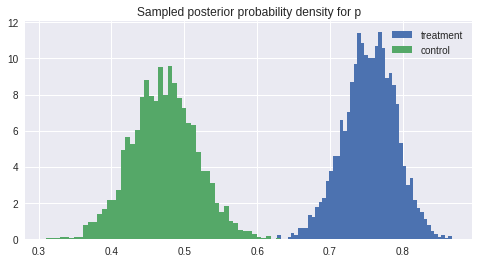

('Posterior 95% interval over p for treatment:', array([0.68089618, 0.82163354]))
('Posterior 95% interval over p for control:', array([0.38385688, 0.56020265]))


In [0]:
# Plot posterior histograms

samples_treatment = results_treatment.extract()
samples_control = results_control.extract()

plt.figure(figsize=(8,4))
plt.hist(samples_treatment['p'], bins=50, density=True, label='treatment')
plt.hist(samples_control['p'], bins=50, density=True, label='control')
plt.title('Sampled posterior probability density for p')
plt.legend()
plt.show()

print('Posterior 95% interval over p for treatment:', np.percentile(samples_treatment['p'], [2.5, 97.5]))
print('Posterior 95% interval over p for control:', np.percentile(samples_control['p'], [2.5, 97.5]))

## Tasks
Work through as many of these tasks as you can, but do at least the first 4.

1. Copy the Stan code above and modify it to have a different $p_i$ per study and a prior over $\alpha$ and $\beta$.
   1. Make the `p` parameter a list of length `num_trials` rather than a single value.
   2. Make `alpha` and `beta` parameters rather than data.
   3. Put a prior on `alpha` and `beta`. Do this in the model block of the Stan code.
   4. Further modify the model block of the Stan code so that each `p[i]` is generated independently from the Beta(α,β) distribution.
2. Compile the model (this will take at least 1 minute).
3. Generate inference results using the `sampling` function.
4. Print out the Stan summary of the results.
    * Remember to include α and β in the list of parameters so you can see their posterior values.
    * **If your results don't make sense, check your Stan code for bugs.**
    * It's easy to make mistakes.
5. Plot a histogram of the posterior over $\alpha$ and $\beta$ for the treatment and control groups.
    1. How do these inferred values for $\alpha$ and $\beta$ differ from our original setting $\alpha = \beta = 1$?
    2. What do these posteriors over $\alpha$ and $\beta$ tell us about the difference between the treatment and control groups?
    3. What do these posteriors over $\alpha$ and $\beta$ tell us about what to expect from future medical studies?
6. Plot histograms over the posteriors over $p_1, p_2, ..., p_6$ for the treatment and control groups.
    * Based on these posteriors, do you think the $p_i$ really are different between the different studies?
    * Or are they the same?

The new model, repeated for convenience:
$$\begin{align}
\alpha &\sim \text{Exponential}(\lambda=0.5) \\
\beta &\sim \text{Exponential}(\lambda=0.5) \\
p_i &\sim \text{Beta}(\alpha, \beta)\\
k_{i} &\sim \text{Binomial}(n_{i}, p_i) \qquad i=1,2,\ldots 6
\end{align}$$

In [0]:
stan_code = """

// The data block contains all known quantities - typically the observed
// data and any constant hyperparameters.
data {
    int<lower=1> num_trials;  // number of trials in the data set
    int<lower=0> patients[num_trials];  // number of patients per trial
    int<lower=0> improved[num_trials];  // number of improved patients per trial
    real<lower=0> lambda_a;
    real<lower=0> lambda_b;
}

// The parameters block contains all unknown quantities - typically the
// parameters of the model. Stan will generate samples from the posterior
// distributions over all parameters.
parameters {
    real<lower=0,upper=1> p[num_trials];  // probability of improvement - the
                              // parameter of the binomial likelihood
    real<lower=0> alpha;  // fixed prior hyperparameter
    real<lower=0> beta;   // fixed prior hyperparameter
}

// The model block contains all probability distributions in the model.
// This of this as specifying the generative model for the scenario.
model {
    alpha ~ exponential(lambda_a);
    beta ~ exponential(lambda_b);
    for(i in 1:num_trials) {
        improved[i] ~ binomial(patients[i], p[i]);  // likelihood function
        p[i] ~ beta(alpha, beta);  // prior over p;
     
    }
}

"""

In [0]:
# Compile the model
stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ceebec28fbc4656da8361e3f978fce20 NOW.
/usr/local/lib/python2.7/dist-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmpUYzrBx/stanfit4anon_model_ceebec28fbc4656da8361e3f978fce20_8863803532383583334.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [0]:
eczema_data_new = {
    'treatment': {
        'lambda_a': 0.5,  # fixed prior hyperparameters for the
        'lambda_b': 0.5,   # beta distribution
        'num_trials': 6,  # number of trials in the data set
        'patients': [23, 16, 16, 45, 31, 10],  # number of patients per trial
        'improved': [20, 10, 13, 35, 22, 7]},  # number of improved patients per trial
    'control': {
        'lambda_a': 0.5,
        'lambda_b': 0.5,
        'num_trials': 6,
        'patients': [15, 18, 10, 39, 29, 10],
        'improved': [9, 11, 4, 21, 12, 0]}}

In [0]:
# Generate posterior samples

results_treatment = stan_model.sampling(data=eczema_data_new['treatment'])
results_control = stan_model.sampling(data=eczema_data_new['control'])

In [0]:
# Print Stan summary of parameter posteri# Print Stan summary of parameter posteriors

print('\nTreatment group results:\n')
print(results_treatment.stansummary(pars=['p'], probs=[0.025, 0.975]))
print('\nControl group results:\n')
print(results_control.stansummary(pars=['p'], probs=[0.025, 0.975]))



Treatment group results:

Inference for Stan model: anon_model_ceebec28fbc4656da8361e3f978fce20.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean     sd   2.5%  97.5%  n_eff   Rhat
p[1]   0.83  1.1e-3   0.07   0.68   0.95 4128.0    1.0
p[2]   0.65  1.6e-3    0.1   0.44   0.83 3854.0    1.0
p[3]   0.79  1.3e-3   0.09    0.6   0.93 4282.0    1.0
p[4]   0.77  8.5e-4   0.06   0.65   0.87 4722.0    1.0
p[5]   0.71  1.2e-3   0.08   0.55   0.84 4236.0    1.0
p[6]   0.71  1.6e-3   0.11   0.47   0.89 4583.0    1.0

Samples were drawn using NUTS at Sat Nov 10 12:18:01 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

Control group results:

Inference for Stan model: anon_model_ceebec28fbc4656da8361e3f978fce20.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain

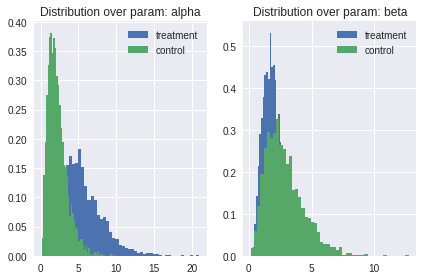

In [0]:
# Generate posterior samples
%matplotlib inline
samples_treatment = results_treatment.extract()
samples_control = results_control.extract()

params = ["alpha", "beta"]
for index, param in enumerate(params):
    plt.subplot(121+index)
    plt.hist(samples_treatment[param], bins=50, density=True, label='treatment')
    plt.hist(samples_control[param], bins=50, density=True, label='control')
    plt.legend()
    plt.title("Distribution over param: {}".format(param))

plt.tight_layout()
plt.show()

# Plot posterior histograms over alpha and beta for the treatment and control groups


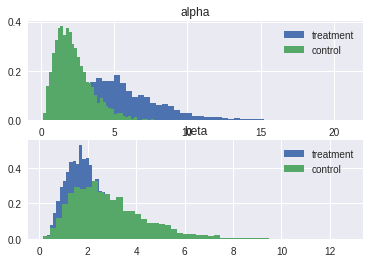

In [0]:
plt.subplot(2,1,1)
plt.hist(samples_treatment['alpha'], bins=50, density=True, label='treatment')

plt.hist(samples_control['alpha'], bins=50, density=True, label='control')
plt.title('alpha')
plt.legend()

plt.subplot(2,1,2)
plt.hist(samples_treatment['beta'], bins=50, density=True, label='treatment')

plt.hist(samples_control['beta'], bins=50, density=True, label='control')
plt.title('beta')
plt.legend()
plt.show()

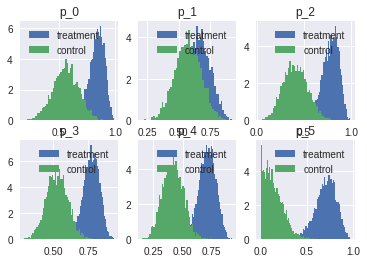

In [0]:
# Plot posterior histograms over p_i for the treatment and control groups
for _ in range(6):
    plt.subplot(2,3,_+1)
    plt.hist(samples_treatment['p'][:,_], bins=50, density=True, label='treatment')

    plt.hist(samples_control['p'][:,_], bins=50, density=True, label='control')
    plt.title('p_{}'.format(_))
    plt.legend()
plt.show()

In [0]:
samples_treatment['p'][:,0]

array([0.89085941, 0.59967878, 0.86792407, ..., 0.87610996, 0.76231693,
       0.83614047])